In [ ]:
from commonfunctions import *
import cv2
import numpy as np 
import matplotlib.pyplot as plt 
#import pytesseract 
from PIL import Image
plt.style.use('dark_background')

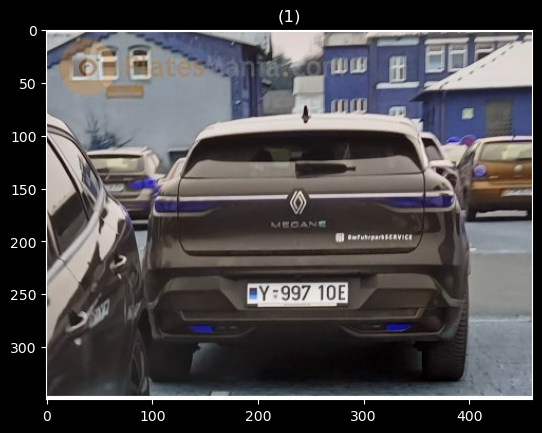

In [ ]:
original_img = cv2.imread('16.jpg')
if len(original_img.shape) == 3:
    height , width , channel = original_img.shape
elif len(original_img.shape) == 2:
    height , width  = original_img.shape

show_images([original_img])

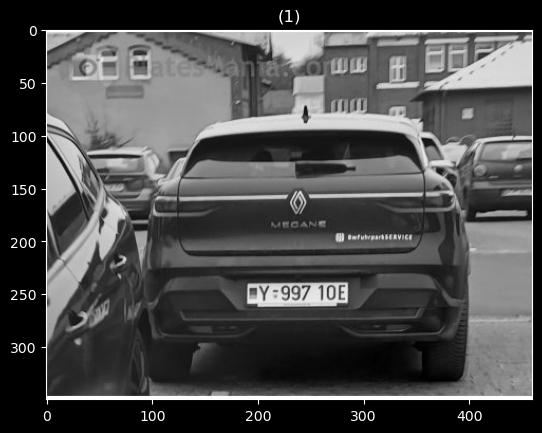

In [ ]:
gray_img = cv2.cvtColor(original_img , cv2.COLOR_BGR2GRAY)
show_images([gray_img])


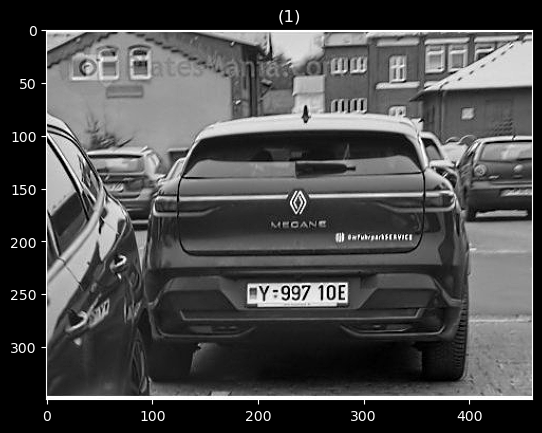

In [ ]:
structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT , (3,3))
imgTopHat = cv2.morphologyEx(gray_img,cv2.MORPH_TOPHAT ,structuringElement )
imgBlackHat = cv2.morphologyEx(gray_img,cv2.MORPH_BLACKHAT ,structuringElement )
gray_img_plus_TopHat = cv2.add(gray_img , imgTopHat)
gray_img = cv2.subtract(gray_img_plus_TopHat , imgBlackHat)
show_images([gray_img])

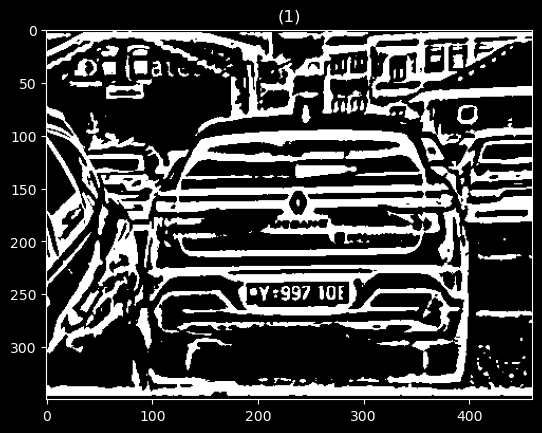

In [ ]:
blurred_img = cv2.GaussianBlur(gray_img , ksize=(5,5) , sigmaX=0)
thresholded_img = cv2.adaptiveThreshold(blurred_img , maxValue=255.0 , adaptiveMethod=cv2.ADAPTIVE_THRESH_MEAN_C
                                        ,thresholdType=cv2.THRESH_BINARY_INV, blockSize=19,C=9)


show_images([thresholded_img  ])

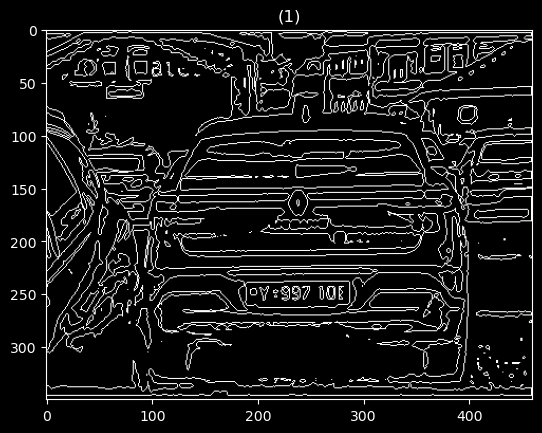

In [ ]:

contours ,_ = cv2.findContours(thresholded_img , mode = cv2.RETR_LIST , method=cv2.CHAIN_APPROX_SIMPLE)
temp_result = np.zeros((height,width,channel),dtype=np.uint8)
cv2.drawContours(temp_result , contours=contours , contourIdx=-1 , color=(255,255,255))
show_images([temp_result])

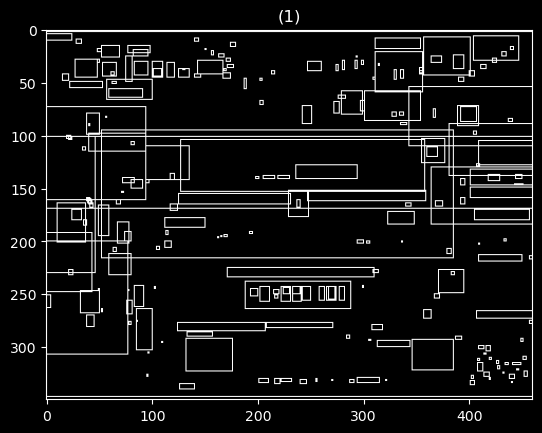

In [ ]:
temp_result = np.zeros((height,width,channel),dtype=np.uint8)
contours_dict=[]

for contour in contours:
    x,y,w,h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result , pt1=(x,y),pt2=(x+w,y+h) , color=(255,255,255) , thickness=1)
    #insert the rectangles into the dict
    contours_dict.append({'contour' : contour , 'x':x,'y':y,'w':w,'h':h ,'cx':x+(w/2),'cy': y+(h/2)})
show_images([temp_result])


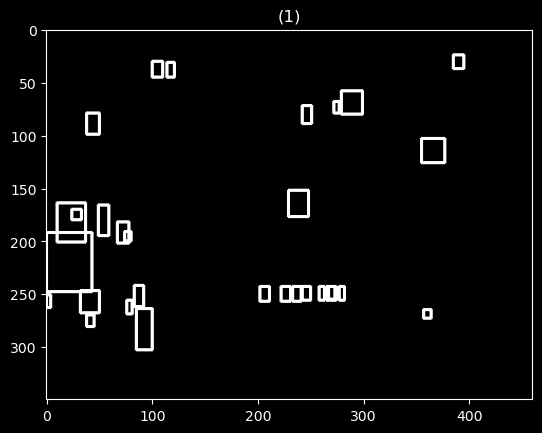

In [ ]:
min_area = 40
max_area = 3000
min_width , min_height = 1,4
min_ratio , max_ratio = 0.25 , 1.0

possible_contours = []

cnt = 0

for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']

    if min_area<area <max_area  and d['w'] > min_width and d['h'] > min_height and min_ratio < ratio <max_ratio:
        d['idx'] = cnt
        cnt +=1
        possible_contours.append(d)

temp_result = np.zeros((height,width,channel),dtype=np.uint8)
for d in possible_contours:
    cv2.rectangle(temp_result , pt1=(d['x'],d['y']) , pt2=(d['x']+d['w'] , d['y']+d['h']) , color=(255,255,255) , thickness=2)

show_images([temp_result])


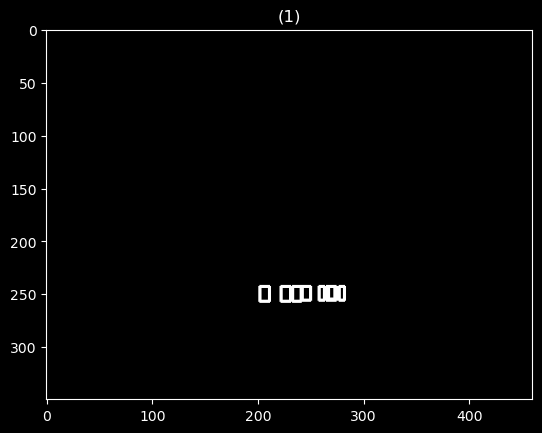

In [ ]:
max_diag_multiplyer = 5
max_angle_diff = 25.0
max_area_diff = 0.5
max_width_diff = 0.8
max_height_diff = 0.2
min_n_matched = 3

def find_chars(contours_list):
    matched_result_idx = []

    for d1 in contours_list:
        matched_contour_idx = []
        for d2 in contours_list:
            if d1['idx'] == d2['idx']:
                continue

            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])

            diagonal_length = np.sqrt(d1['w']**2 + d1['h']**2)
            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))

            angle_diff = 90 if dx == 0 else np.degrees(np.arctan(dy / dx))
            
            area_diff = abs((d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h']))
            width_diff = abs((d1['w'] - d2['w']) / d1['w'])
            height_diff = abs((d1['h'] - d2['h']) / d1['h'])

            if distance < diagonal_length * max_diag_multiplyer and angle_diff < max_angle_diff \
                and area_diff < max_area_diff and width_diff < max_width_diff and height_diff < max_height_diff:
                matched_contour_idx.append(d2['idx'])

        if len(matched_contour_idx) < min_n_matched:
            continue

        matched_result_idx.append([d1['idx']] + matched_contour_idx)

        unmatched_contour_idx = [d4['idx'] for d4 in contours_list if d4['idx'] not in matched_contour_idx]

        if not unmatched_contour_idx:
            break

        unmatched_contour = np.array([d for d in contours_list if d['idx'] in unmatched_contour_idx])
        recursive_contour_list = find_chars(unmatched_contour)

        for idx in recursive_contour_list:
            matched_result_idx.append(idx)

        break

    return matched_result_idx

result_idx = find_chars(possible_contours)

matched_result = []

for idx_list in result_idx:
    matched_result.append(np.take(possible_contours , idx_list))



temp_result = np.zeros((height,width,channel),dtype=np.uint8)

for r in matched_result:
    for d in r:
        
        cv2.rectangle(temp_result , pt1=(d['x'],d['y']) , pt2=(d['x']+d['w'] , d['y']+d['h']) , color=(255,255,255) , thickness=2)

show_images([temp_result])


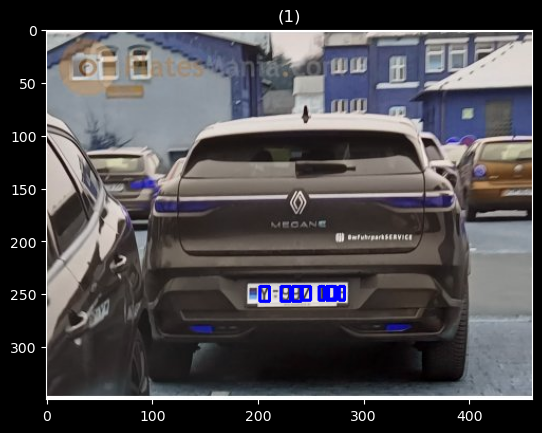

In [ ]:
result_idx = find_chars(possible_contours)

matched_result = []

for idx_list in result_idx:
    matched_result.append(np.take(possible_contours , idx_list))



temp_result = np.zeros((height,width,channel),dtype=np.uint8)

for r in matched_result:
    for d in r:
        
        cv2.rectangle(original_img , pt1=(d['x'],d['y']) , pt2=(d['x']+d['w'] , d['y']+d['h']) , color=(0,0,255) , thickness=2)

show_images([original_img])

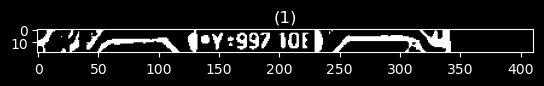

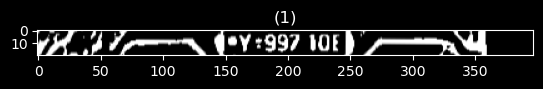

In [ ]:
plate_width_padding = 1.5
plate_height_padding = 1.5
min_plate_ratio = 3
max_plate_ratio = 10


plate_imgs = []
plate_infos = []

for i , matched_chars in enumerate(matched_result):
    sorted_chars = sorted(matched_chars , key=lambda x : x['cx'])

    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) /2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) /2

    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['w'] ) * plate_width_padding

    sum_height = 0
    cropped_imgs = []
    for d in sorted_chars:
        sum_height += d['h']


    plate_height = int(sum_height / len(sorted_chars) * plate_height_padding)

    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'] , sorted_chars[0]['cy']]) -
        np.array([sorted_chars[-1]['cx'] , sorted_chars[-1]['cy']])
    )

    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))

    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx , plate_cy) , angle=angle , scale=1.0)

    img_rotated = cv2.warpAffine(thresholded_img , M=rotation_matrix , dsize=(width, height))

    img_cropped = cv2.getRectSubPix(
        img_rotated,
        patchSize=(int(plate_width) , int(plate_height)),
        center = (int(plate_cx) , int(plate_cy))
    )

    if img_cropped.shape[1] / img_cropped.shape[0] < min_plate_ratio or min_plate_ratio < img_cropped.shape[1] / img_cropped.shape[0] <  max_plate_ratio:
        continue


    plate_imgs.append(img_cropped)
    
    plate_infos.append({
        'x':int(plate_cx - plate_width /2),
        'y':int(plate_cy - plate_height /2),
        'w':int(plate_width),
        'h':int(plate_height)
    })

    show_images([img_cropped])






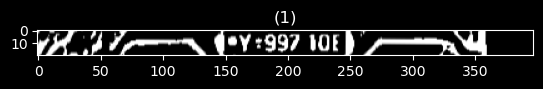

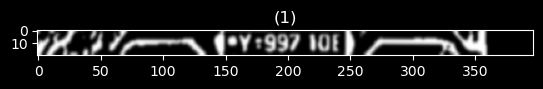

In [ ]:
def detect_number_rectangle(img):
    """
    Detect the rectangle containing numbers in an image.

    Parameters:
        image_path (str): Path to the input image file.

    Returns:
        (bool, ndarray or None): 
            - True and the cropped image if the rectangle is found.
            - False and None if no rectangle is found.
    """
    

    # Apply edge detection
    edges = cv2.Canny(img, 50, 200)  # Canny edge detection

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Loop through contours to find the rectangle
    for contour in contours:
        # Approximate the contour to a polygon
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Check if the polygon has 4 sides (rectangle)
        if len(approx) == 4:
            # Compute the bounding rectangle
            x, y, w, h = cv2.boundingRect(approx)

            # Set aspect ratio and size constraints (typical for number plates)
            aspect_ratio = w / h
            if 3 <= aspect_ratio <= 7 and w > 50 and h > 20:  # Adjust thresholds as needed
                # Draw the rectangle on the original image
                rect_img = img.copy()
                cv2.rectangle(rect_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

                # Crop the region containing the rectangle
                cropped_img = img[y:y+h, x:x+w]

                # Return the cropped image and True
                return True, cropped_img

    # If no valid rectangle is found
    return False, None


image = plate_imgs[1]

show_images([image])



blur = cv2.GaussianBlur(image, (5,5), 0)
show_images([blur])

contours, _ = cv2.findContours(blur, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key = cv2.contourArea, reverse = True)[:5]

found = False
for c in contours:
    peri = cv2.arcLength(c, True)
    
    approx = cv2.approxPolyDP(c,0.02*peri, True)
    if len(approx) == 4:
        print(True)
        found = True
        n_plate_cnt = approx
        (x, y, w, h) = cv2.boundingRect(n_plate_cnt)
        license_plate = image[y:y + h, x:x + w]
        break

if found :
    cv2.drawContours(image, [n_plate_cnt], -1, (0, 255, 0), 3)
    show_images( [image,blur ])
    
# Example usage:



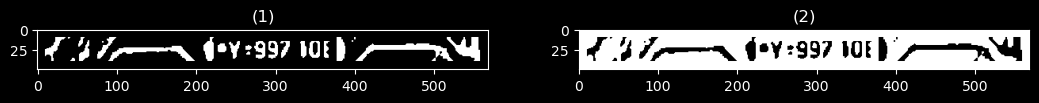

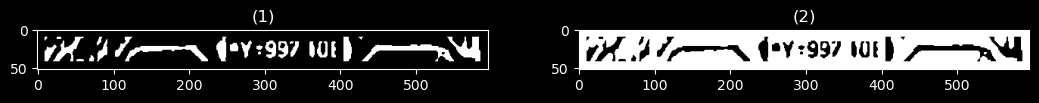

In [ ]:
longest_idx , longest_text = -1 , 0

plate_chars = []
for i, plate_img in enumerate(plate_imgs):
    # Resize the image
    plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)

    # Threshold the image
    _, plate_img = cv2.threshold(plate_img, 127, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(plate_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize bounding box variables
    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0

    # Filter contours and update bounding box
    valid_contours = [
        cv2.boundingRect(c)
        for c in contours
        if min_area < cv2.contourArea(c) < max_area
    ]
    if valid_contours:
        plate_min_x = min([x for x, _, _, _ in valid_contours])
        plate_min_y = min([y for _, y, _, _ in valid_contours])
        plate_max_x = max([x + w for x, _, w, _ in valid_contours])
        plate_max_y = max([y + h for _, y, _, h in valid_contours])

    # Crop the image to the detected plate region
    img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]

    # Apply Gaussian blur and threshold
    img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
    _, img_result = cv2.threshold(
        img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU
    )

    # Add a border
    img_result = cv2.copyMakeBorder(
        img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0)
    )
    negative_img = 255-img_result
    

    # Display results
    
    show_images([img_result ,negative_img])
            

In [ ]:
def find_contours(dimensions , img):
    #find all the contours in the image
    contours , _ = cv2.findContours(negative_img.copy() , cv2.RETR_TREE , cv2.CHAIN_APPROX_SIMPLE)
    #retrieve potential dimensions

    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]

    contours = sorted(contours , key=cv2.contourArea , reverse=True)[:15]

    ii = cv2.imread('contour.jpg')

    x_cntr_list = []
    traget_contours = []
    img_res = []

    for contour in contours:
        #detect the contour in binary image and return the coordinate of rectangle enclosing it
        intX , intY , intWidth , intHeight = cv2.boundingRect(contour)

        #check the diementions of the contour to filter out the characters by contour size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight< upper_height:
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour . to use it later for indexing the contours

            char_copy = np.zeros((44,24))
            #extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY + intHeight , intX : intX + intWidth]

            char = cv2.resize(char ,(20,40) )

            cv2.rectangle(ii ,(intX , intY) , (intX+intWidth , intY+intHeight) , (50,21,200) , 2)
            
            show_images([ii])

            #make result formatted for classification: invert colors

            char = cv2.subtract(255 , char)

            #resize the image to 24x44 with black border
            char_copy[2:42 , 2:22] = char
            char_copy[0:2 , : ] = 0
            char_copy[ : , 0:2 ] = 0
            char_copy[42:44 , :] =0
            char_copy[: , 22:44] = 0

            img_res.append(char_copy) #list that stores the character's binary image (unsorted)

    #return characters on ascending order wit respect to the x-coordinate (most-left character first)
    # arbitrary function that stores sorted list of character indices
    indices = sorted(range(len(x_cntr_list)) , key= lambda k: x_cntr_list[k])
            
    img_res_copy =[]

    for idx in indices:
        img_res_copy.append(img_res[idx]) #stores character image according to their index
            
    img_res = np.array(img_res_copy)

    return img_res

    



In [ ]:
def segment_character(image):

    #preprocess cropped license plate image

    img_lp = cv2.resize(image , (333,75))

    lp_width = img_lp.shape[0]
    lp_height = img_lp.shape[1]

    #make borders white

    img_lp[0:3 , :] = 255
    img_lp[: , 0:3] = 255
    img_lp[72:75 , :] = 255
    img_lp[: , 330:333] = 255
    
    #estimations of character contours sizes of cropped license plate

    dimensions = [
        lp_width/6,
        lp_width/2,
        lp_height/10,
        2*lp_height/3
    ]
    show_images([img_lp])
    cv2.imwrite('contour.jpg' , img_lp)


    #get contours within cropped license plate
    char_list = find_contours(dimensions , img_lp)

    return char_list



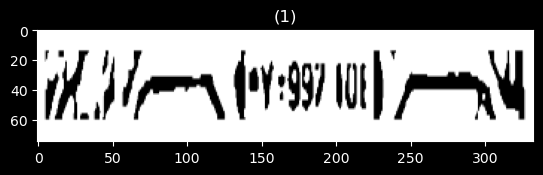

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [ ]:
char = segment_character(negative_img)

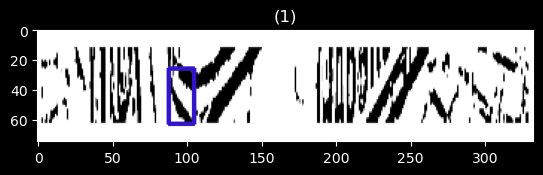

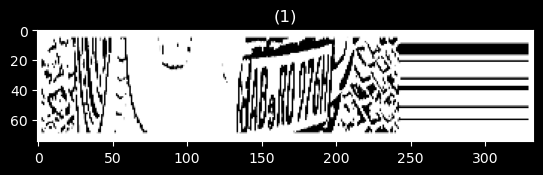

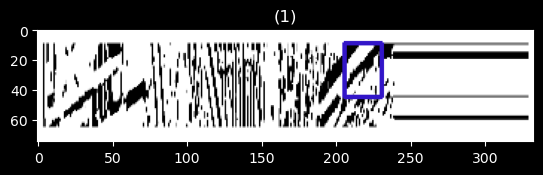

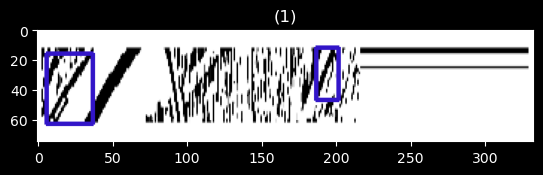

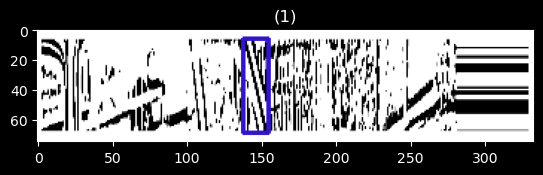

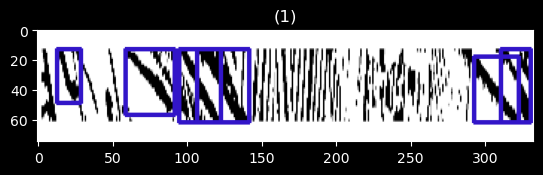

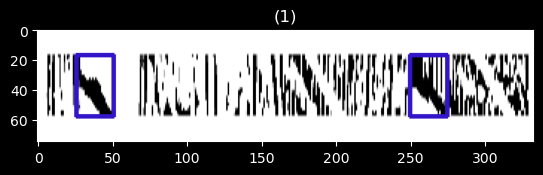

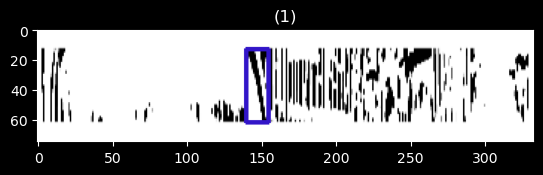

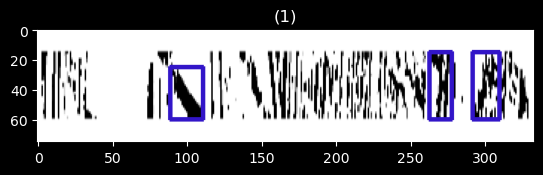

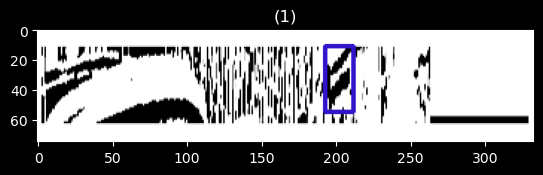

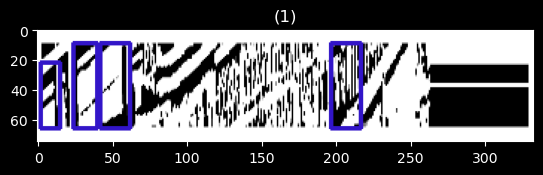

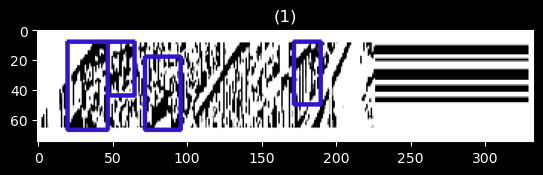

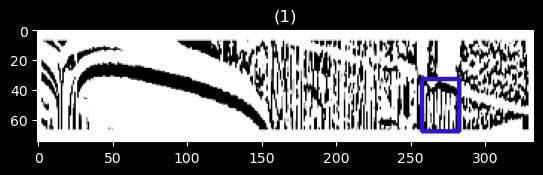

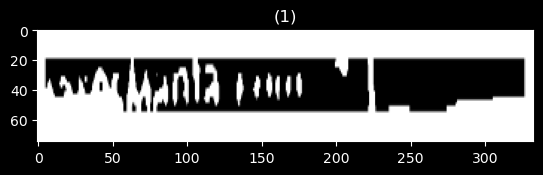

In [ ]:

def find_contours(dimensions, img):
    """
    Finds contours in a single image and processes them based on the given dimensions.

    Parameters:
        dimensions (tuple): Tuple containing (lower_width, upper_width, lower_height, upper_height).
        img (ndarray): Single preprocessed image.

    Returns:
        img_res (list): List of processed character images.
    """
    # Find all contours in the image
    contours, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width, upper_width, lower_height, upper_height = dimensions

    # Sort contours by area, keep the top 15
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:15]

    x_cntr_list = []
    img_res = []

    # Optional: Visualization image to show bounding boxes
    contour_img = cv2.cvtColor(img.copy(), cv2.COLOR_GRAY2BGR)

    for contour in contours:
        # Detect the contour in the binary image and get its bounding box
        intX, intY, intWidth, intHeight = cv2.boundingRect(contour)

        # Filter contours by dimensions
        if lower_width < intWidth < upper_width and lower_height < intHeight < upper_height:
            x_cntr_list.append(intX)  # Store the x-coordinate for sorting

            char_copy = np.zeros((44, 24))
            # Extract character using the bounding rectangle's coordinates
            char = img[intY:intY + intHeight, intX:intX + intWidth]

            # Resize the character to standard size (20x40)
            char = cv2.resize(char, (20, 40))

            # Invert colors for classification
            char = cv2.subtract(255, char)

            # Resize the character to 24x44 with black borders
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy)  # Add processed character to result list

            # Draw bounding box for visualization
            cv2.rectangle(contour_img, (intX, intY), (intX + intWidth, intY + intHeight), (50, 21, 200), 2)

    # Sort characters by x-coordinate (left-to-right order)
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res = [img_res[idx] for idx in indices]

    # Optionally display the visualization
    show_images([contour_img])

    return img_res


def segment_characters_from_images(images):
    """
    Segments characters from a list of license plate images.

    Parameters:
        images (list): List of license plate images (grayscale).

    Returns:
        char_lists (list): A list containing character arrays for each license plate image.
    """
    char_lists = []

    for image in images:
        # Preprocess the license plate image
        img_lp = cv2.resize(image, (333, 75))

        # Add white borders to the license plate image
        img_lp[0:3, :] = 255
        img_lp[:, 0:3] = 255
        img_lp[72:75, :] = 255
        img_lp[:, 330:333] = 255

        # Estimations of character contour sizes for the license plate
        lp_width = img_lp.shape[0]
        lp_height = img_lp.shape[1]
        dimensions = [
            lp_width / 6,       # lower_width
            lp_width / 2,       # upper_width
            lp_height / 10,     # lower_height
            2 * lp_height / 3   # upper_height
        ]

        # Write image for contour debugging (optional)
        cv2.imwrite('contour.jpg', img_lp)

        # Get contours for the current license plate
        char_list = find_contours(dimensions, img_lp)

        # Add result to the list
        char_lists.append(char_list)

    return char_lists




# Process all license plate images
characters = segment_characters_from_images(negative_img)


